In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

print('Imports Complete')

Imports Complete


In [2]:
train = pd.read_csv('covid_19_res.csv', encoding='utf-8')
train.head()

,서울시 기준일,서울시 확진자,서울시 추가 확진,서울시 치료중,서울시 퇴원,서울시 추가 퇴원,서울시 사망,서울시 의심환자 전체,서울시 의심환자 검사중,서울시 의심환자 검사결과(음성),...,전국 의심환자 전체,전국 의심환자 검사중,전국 의심환자 검사결과(음성),자가격리자 해외입국자 감시중,자가격리자 해외입국자 감시해제,자가격리자 접촉자 감시중,자가격리자 접촉자 감시해제,확인중 확진자,서울시 당일사망자,전국 당일 사망자
0,2021.11.04,122789,946,12105,109870.0,719.0,814,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,2021.11.05,123769,980,12217,110734.0,864.0,818,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,2021.11.06,124685,916,12221,111642.0,908.0,822,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,2021.11.07,125533,848,12642,112063.0,421.0,828,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,2021.11.08,126241,709,12994,112414.0,351.0,833,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [3]:
train.shape

(319, 26)

In [4]:
train.index = pd.to_datetime(train['서울시 기준일'], format='%Y.%m.%d.%h',errors='ignore')
time = train.index

<AxesSubplot:xlabel='서울시 기준일'>

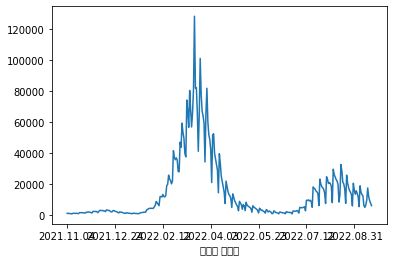

In [5]:
seoul = train['서울시 추가 확진']
seoul.plot()

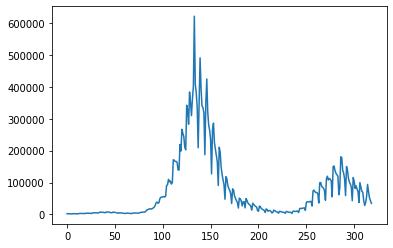

In [6]:
from pandas import read_csv

dataframe = read_csv('covid_19_res.csv', usecols=[12], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

plt.plot(dataset)

In [7]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [8]:
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [9]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 20

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [10]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [24]:
from keras.layers import Dense, SimpleRNN
model = Sequential()
model.add(SimpleRNN(units=64,return_sequences = True, input_shape = (look_back, 1)))
#model.add(Dropout(0.2))
model.add(SimpleRNN(units=64))
#model.add(Dropout(0.2))
model.add(Dense(units = 1))
# Compile Model
model.compile(loss='mse', optimizer='adam')
# Fit Model
history = model.fit(trainX, trainY, epochs=100, batch_size=70, 
                 verbose=False, shuffle=False)

In [25]:
# make predictionsa
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [26]:
from sklearn.metrics import mean_squared_error

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22566.78 RMSE
Test Score: 28234.29 RMSE


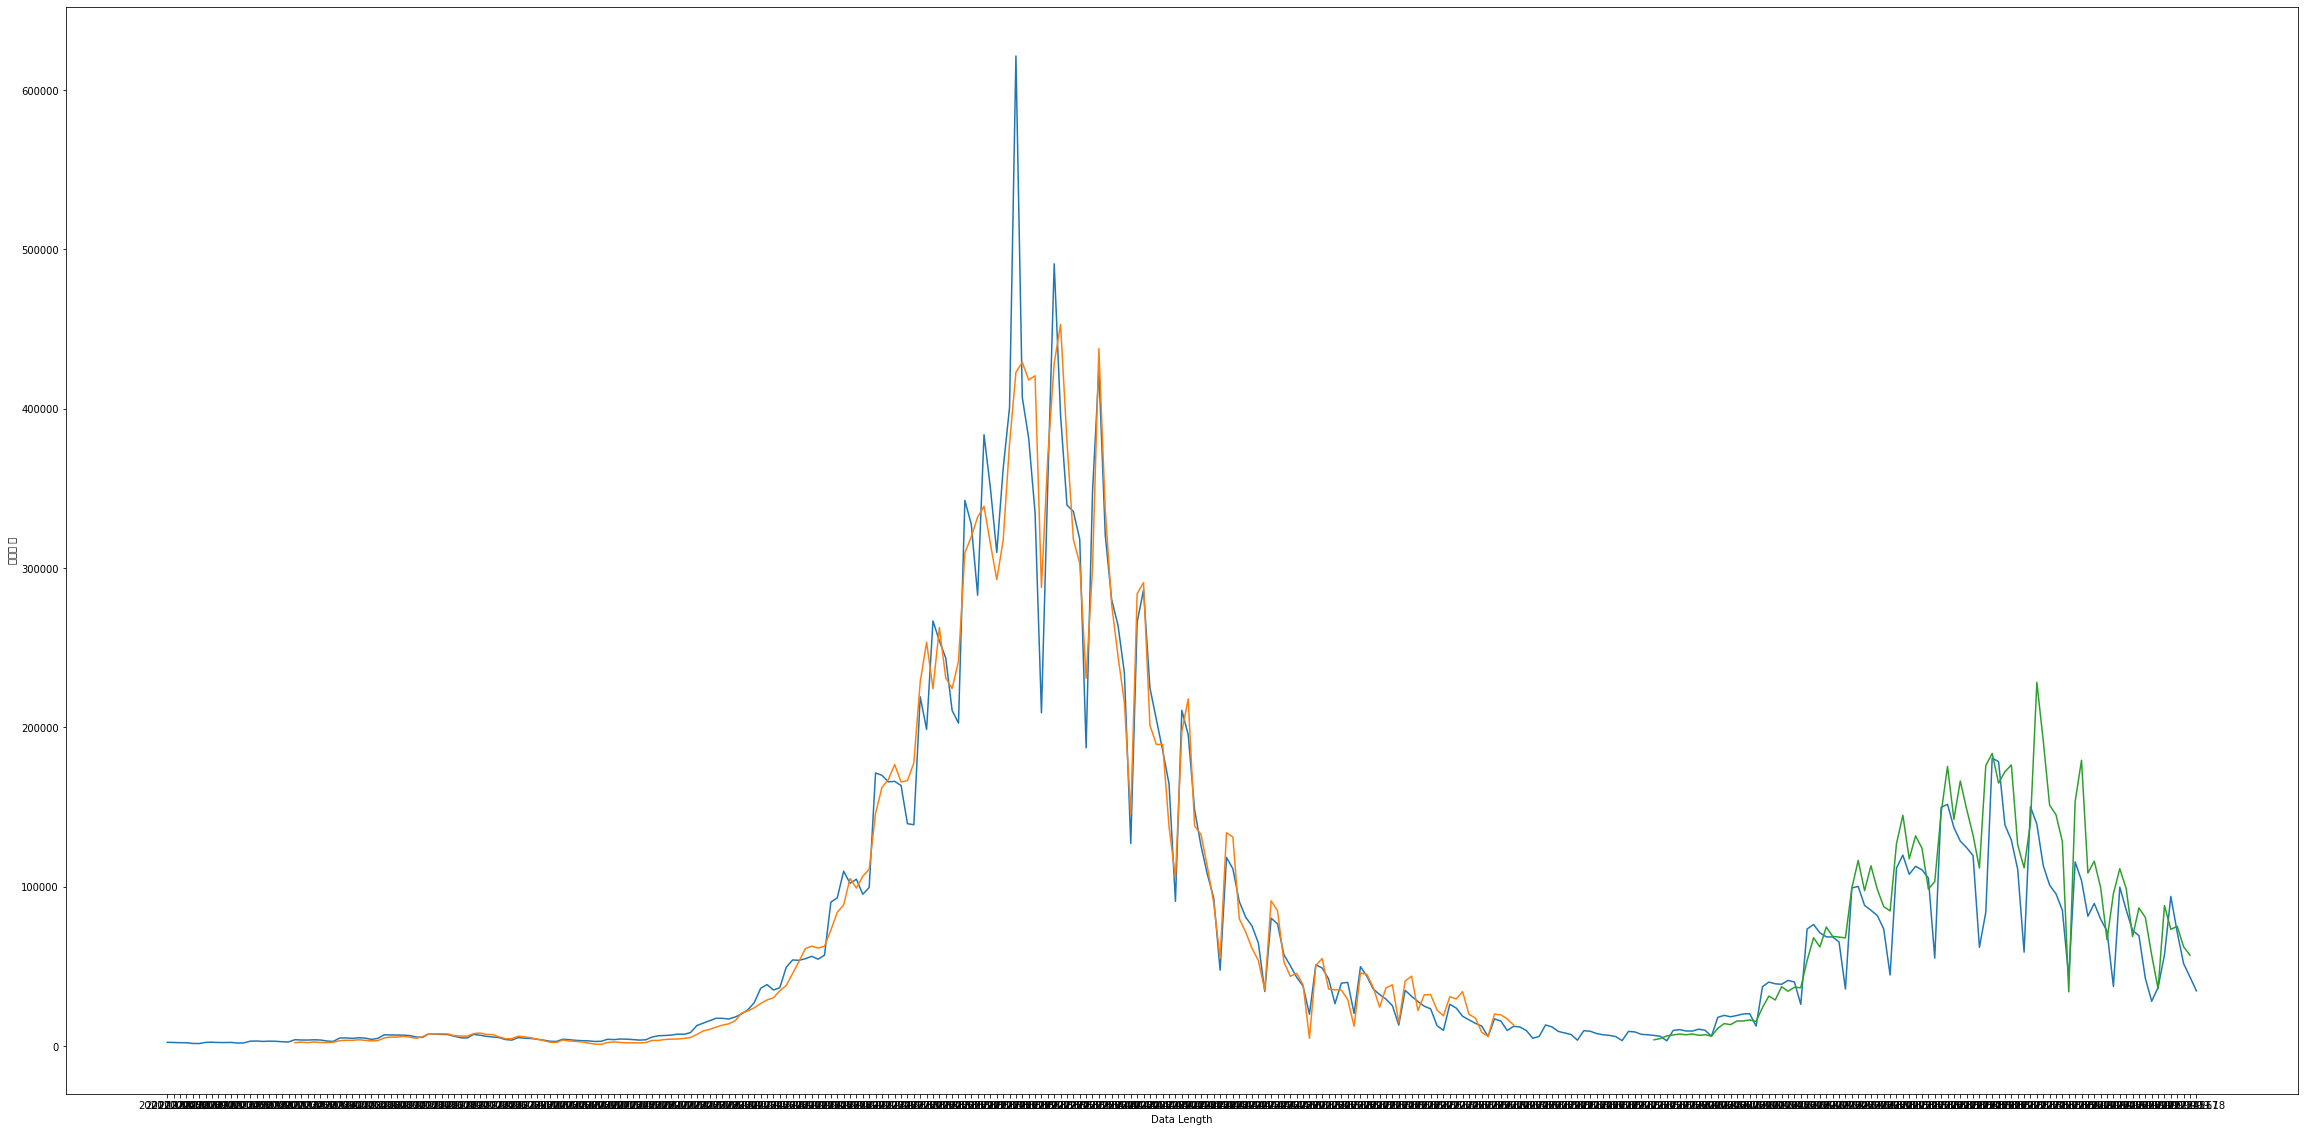

In [27]:

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


korea_TrainPredict = trainPredictPlot
korea_TestPredict = testPredictPlot
# plot baseline and predictions
plt.figure(figsize=(40,20))
plt.plot(time,scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)


plt.xlabel("Data Length")
plt.ylabel("확진자 수")


plt.show()